In [2]:
import numpy
import tensorflow_datasets as tfds


In [3]:
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

In [4]:
print(mnist_dataset)

{'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'test': <_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}


In [5]:
traindf=mnist_dataset['train']
testdf=mnist_dataset['test']


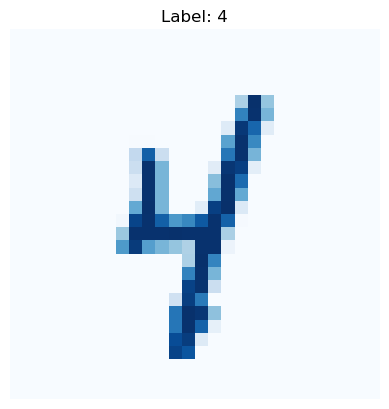

In [6]:
import matplotlib.pyplot as plt

# Extract one batch (or example) from the dataset
for image, label in traindf.take(1):
    # Convert TensorFlow tensors to numpy arrays
    image_np = image.numpy().squeeze()  # Shape: (28, 28, 1) → (28, 28)
    label_np = label.numpy()

    # Plot the image
    plt.imshow(image_np, cmap='Blues')
    plt.title(f"Label: {label_np}")
    plt.axis('off')
    plt.show()

In [2]:
import numpy as np
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [3]:
# when creating a layer think about how the array or layer interacts instead of each individual node
class Layer:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.bias = np.zeros((1, output_dim))#np.zeros creates an array of given length filled with zero
    
    def forward(self,input):
        self.input=input
        self.z=(np.dot(input,self.weights)+self.bias)
        self.z=relu(self.z)
        return self.z
    
    def backward(self, grad, learning_rate):
        delta = grad * relu_derivative(self.z)
        dW = np.dot(self.input.T, delta)
        db = np.sum(delta, axis=0, keepdims=True)
        dW = np.clip(dW, -1, 1)
        db = np.clip(db, -1, 1)
        self.weights -= learning_rate * dW
        self.bias -= learning_rate * db
        grad_prev = np.dot(delta, self.weights.T)
        return grad_prev
    

class Outputlayer(Layer):
    def forward(self, input):
        self.input=input
        self.z=(np.dot(input,self.weights)+self.bias)
        self.z=softmax(self.z)
        return self.z
    
    def backward(self, grad, learning_rate):
        dW = np.dot(self.input.T, grad)
        db = np.sum(grad, axis=0, keepdims=True)
        dW = np.clip(dW, -1, 1)
        db = np.clip(db, -1, 1)
        self.weights -= learning_rate * dW
        self.bias -= learning_rate * db
        return np.dot(grad, self.weights.T)



In [1]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size=1):
        self.layers = []
        sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)):
            self.layers.append(Layer(sizes[i], sizes[i+1]))
        self.layers.append(Outputlayer(hidden_sizes[-1], output_size))
    
    def forward(self, X):
        a = X
        for layer in self.layers:
            a = layer.forward(a)
        return a
    
    def backward(self, X, y, learning_rate):
        y_pred = self.forward(X)
        m = X.shape[0]
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        grad = (y_pred - y) / m
        for layer in reversed(self.layers):
            grad = layer.backward(grad, learning_rate)

In [ ]:
def train_model( input_size, hidden_units, epochs=1000, lr=0.001):
    X_train, y_train = load_data("train.npz")
    X_val, y_val = load_data("val.npz")
    model = NeuralNetwork(input_size=input_size, hidden_sizes=hidden_units, output_size=1)
    for epoch in range(epochs):
        y_pred = model.forward(X_train)
        loss = np.mean((y_pred - y_train) ** 2)
        model.backward(X_train, y_train, lr)
        val_pred = model.forward(X_val)
        val_loss = np.mean((val_pred - y_val) ** 2)
        if epoch % 100 == 0:
            print(f"Epoch {epoch} | Train Loss: {loss:.4f} | Val Loss: {val_loss:.4f}")
    return model
    

In [ ]:
def evaluate_model(model):
    X_test, y_test = load_data("test.npz")
    y_pred = model.forward(X_test)
    loss = -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)).mean()
    